# Feature Engineering and Modeling

## Introduction
Machine learning models require well-engineered features and robust preprocessing to optimize performance, especially when handling imbalanced datasets such as stroke prediction. This section covers feature engineering strategies, model selection, and hyperparameter tuning to improve classification performance.

### Models Used:
1) Random Forest;
2) XGBoost;
3) LightGBM;
4) Bagging with Decision Tree;
5) Decision Tree. 
<br>

### Goal
- Develop and compare tree-based classifiers to predict stroke occurrences.
- Engineer informative features while preserving real-world usability (e.g., missing BMI values).
- Optimize models using hyperparameter tuning, threshold optimization, and feature selection.
- Select and deploy the best model.

### Success Metrics
Stroke is a critical health condition, missing a high-risk patient (false negative) could be life-threatening. Although too many false positives could overburden medical staff with patients who don’t actually need critical care.
Initial choice: 
- Precission recall (PR AUC) is a metric used to evaluate the performance of a binary classification model, especially on **imbalanced datasets.** It measures the area under the Precision-Recall curve, which shows the trade-off between precision and recall at different thresholds.
Secondary choice:
- F1 Score - The harmonic mean of precision and recall ensures a good balance between both.

### More on Data
Please read more in eda notebook Closing Remarks for the EDA section.

## Points for Discussion (Technical Aspects)
- Automated feature engineering: should it be just go to practice?
- Feature engineering seems to introduce multicollinearity.

# Imports and Configuration
The goal is to make sure that all the required libraries and packages are loaded, as well as notebook defaults are set at the beginning of the notebook, ensuring code has access to the necessary tools and functions.

In [1]:
import pandas as pd
import json

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from autofeat import AutoFeatRegressor
import joblib
import shap


from utils.ml_utils import (
    preprocess_features,
    compute_mutual_information,
    score_dataset_classification_task,
    create_ordinal_bins,
    select_features_lasso_kbest,
    select_features_rfe_lasso,
    create_dynamic_preprocessor,
    compute_classification_metrics,
    train_and_evaluate_models_no_smote,
)

from utils.vizualization_utils import (
    plot_horizontal_bars,
    plot_cv_boxplot,
    plot_confusion_matrices,
    plot_shap_summary,
)

from utils.stats_utils import (
    encode_nominal_categorical_features,
)

import warnings

warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

# Data Loading
The goal is to load all relevant data files into your notebook environment, making them accessible for analysis in subsequent cells.

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
target_column = "stroke"

## Statistical Data Types Encoding

In [3]:
with open("data/nominal_category_mappings.json", "r") as f:
    nominal_category_mappings = json.load(f)

In [4]:
train_df_encoded = encode_nominal_categorical_features(
    df=train_df, mapping_dict=nominal_category_mappings
)
train_df_encoded["bmi_missing"] = train_df_encoded["bmi"].isnull().astype(int)
train_df_encoded["avg_glucose_level_outlier"] = (
    train_df_encoded["avg_glucose_level"] >= 169
).astype(int)
test_df_encoded = encode_nominal_categorical_features(
    df=test_df, mapping_dict=nominal_category_mappings
)
test_df_encoded["bmi_missing"] = test_df_encoded["bmi"].isnull().astype(int)
test_df_encoded["avg_glucose_level_outlier"] = (
    test_df_encoded["avg_glucose_level"] >= 169
).astype(int)
X_train = train_df_encoded.copy()
y_train = X_train.pop(target_column)
X_test = test_df_encoded.copy()
y_test = X_test.pop(target_column)
original_features = X_train.columns.to_list()

# Feature Egineering
## Feature  Utility Scores
Mutual information can be used to compute a utility score for a feature, giving an indication of how much potential the feature has.

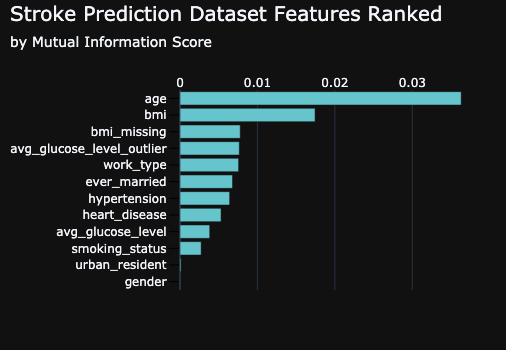

In [5]:
mutual_information_df = compute_mutual_information(X=X_train, y=y_train)
plot_horizontal_bars(
    df=mutual_information_df,
    feature_column="feature",
    values_column="mutual_information",
    height_px=350,
)

**Notes on mutual information score:**
- Age is by far the most predictive feature. This makes sense since stroke risk increases significantly with age.
    - To try: binning age into categories (e.g., <30, 30-50, 50+) to capture nonlinear relationships.
- BMI has moderate importance. Could interact with other health-related factors (hypertension, heart disease).
    - To try: creating an interaction term (e.g., bmi * hypertension).
- Work Type might indicate more stress for self-employed individuals.
- Ever married might correlate with age.
- Hypertension and Heart Disease, shows some predictive power, but not as much as expected.
- Surprisingly, Average Glucose Level is Not That Informative
    - To try: grouping them into categories.
- Smoking Status Has Low MI Score
    - Unknown values might be affecting MI calculation.
    - To try: Consider imputing missing smoking status.
- Residence Type and Gender have almost no impact, as confirmed by statistical testing.
    - To try: removing them or testing their interaction with other variables.

## Baseline Score
Including a baseline score is an important step in any ML project because it:
- Provides a reference point to measure improvement and helps to justify model choices by comparing performance.
- Prevents over-engineering (e.g., if a simple model performs well, complex models may not be needed).
<br>
The simplest reasonable model that fits the problem should be used as a baseline. For this project chosel model:
    - Dummy Classifier by scikit-learn with stratified srategy (good to compare models, but not features).
    - Other option could be logistic regression.

In [6]:
logistic_score = score_dataset_classification_task(
    X_train, y_train, LogisticRegression(max_iter=10000)
)
print(f"Logistic Regression score (precision recall AUC): {logistic_score:.4f}")

dummy_classifier_score = score_dataset_classification_task(X_train, y_train)
print(f"Baseline score (precision recall AUC): {dummy_classifier_score:.5f} ")

Logistic Regression score (precision recall AUC): 0.2322
Baseline score (precision recall AUC): 0.04966 


**Note on baseline score:**
- The baseline model (dummy classifier) uses stratified predictions, where the model randomly assigns 1 (stroke) ≈ 5% of the time and 0 (no stroke) ≈ 95% of the time, mimicking the dataset’s class distribution.
    - Since PR-AUC rewards recall and precision trade-off, but the model predicts very few positives (1s), the precision remains close to 5%, leading to a PR-AUC ≈ 0.04878.
    - Any real model that significantly beats this score is learning something useful.
    - If a trained model achieves PR-AUC close to 0.05, it is no better than random.
- Logistic regression score is much better, but there is lots of place for improvement.

## Feature Creation and Evaluation
The goal of this section is to explore numerical feature transformation by binning into ordinal categories.

### Turning Continuous Features into Categories

In [7]:
binning_info = {
    "age": {
        "bins": [0, 18, 40, 60, 100],
        "labels": ["child", "young_adult", "middle_aged", "senior"],
    },
    "bmi": {
        "bins": [0, 18.5, 24.9, 29.9, 100],
        "labels": ["underweight", "normal", "overweight", "obese"],
        "add_unknown": True,
    },
    "avg_glucose_level": {
        "bins": [0, 70, 140, 200, 300],
        "labels": ["normal", "pre_diabetes", "diabetes", "severe_diabetes"],
    },
}
X_train = create_ordinal_bins(X=X_train, binning_info=binning_info)
X_test = create_ordinal_bins(X=X_test, binning_info=binning_info)

**Note for the future reference:** if no EDA is done after binnig, it would simplify modeling part if binned categorical features would be statistically encoded right away, espetially if these features are further used in feature engineering.

### Feature interactions
Theoretical background for interactions terms:
- Joint health condition risk;
- Older individuals with higher BMI may have higher stroke risk;
- Blood sugar impact increases with age;
- High BMI & high glucose together may increase health risks.

In [8]:
def add_feature_interactions(X: pd.DataFrame) -> pd.DataFrame:
    """
    Adds interaction features to the dataset based on existing numerical columns.

    Parameters
    ----------
    X : pd.DataFrame
        Input DataFrame containing at least the columns:
        - "hypertension"
        - "heart_disease"
        - "bmi"
        - "age"
        - "avg_glucose_level"

    Returns
    -------
    pd.DataFrame
        DataFrame with additional feature interactions.
    """
    X["hypertension_heart_disease_interaction"] = X["hypertension"] * X["heart_disease"]

    X["bmi_age_interaction"] = X["bmi"] * X["age"]
    X["glucose_age_interaction"] = X["avg_glucose_level"] * X["age"]
    X["bmi_glucose_interaction"] = X["bmi"] * X["avg_glucose_level"]

    X["bmi_per_age"] = X["bmi"] / (X["age"] + 1)
    X["glucose_per_age"] = X["avg_glucose_level"] / (X["age"] + 1)
    X["glucose_per_bmi"] = X["avg_glucose_level"] / (X["bmi"] + 1)


add_feature_interactions(X_train)
add_feature_interactions(X_test)

### Group Transformations
Additional theoretical background:
- Smoking increases insulin resistance, making it harder for the body to use glucose effectively. This raises fasting blood glucose levels;
- Smokers tend to have a lower average BMI compared to non-smokers, likely due to nicotine's appetite-suppressing effects and increased metabolic rate;
- Activity levels differ by job, thus BMI might be different depending on a job;
- Older people tend to have higher BMI;
- People with higher BMI tend to have higher blood pressure and also higher risk of heart diseases;
- Marriage status somewhat correlates with the age, so does a work type.

In [9]:
def add_group_transformations(X: pd.DataFrame) -> pd.DataFrame:
    """
    Adds group-based transformations to the dataset using median values
    from categorical groupings.

    Parameters
    ----------
    X : pd.DataFrame
        Input DataFrame containing at least the following columns:
        - "smoking_status"
        - "age_group"
        - "bmi_group"
        - "work_type"
        - "avg_glucose_level_group"
        - "hypertension"
        - "heart_disease"
        - "ever_married"
        - "avg_glucose_level"
        - "bmi"
        - "age"

    Returns
    -------
    pd.DataFrame
        DataFrame with additional group-based median transformations.
    """

    X["glucose_by_smoking"] = X.groupby("smoking_status", observed=False)[
        "avg_glucose_level"
    ].transform("median")
    X["glucose_by_age_group"] = X.groupby("age_group", observed=False)[
        "avg_glucose_level"
    ].transform("median")
    X["glucose_by_bmi_group"] = X.groupby("bmi_group", observed=False)[
        "avg_glucose_level"
    ].transform("median")

    X["bmi_by_smoking"] = X.groupby("smoking_status", observed=False)["bmi"].transform(
        "median"
    )
    X["bmi_by_work_type"] = X.groupby("work_type", observed=False)["bmi"].transform(
        "median"
    )
    X["bmi_by_age_group"] = X.groupby("age_group", observed=False)["bmi"].transform(
        "median"
    )
    X["bmi_by_glucose_group"] = X.groupby("avg_glucose_level_group", observed=False)[
        "bmi"
    ].transform("median")
    X["bmi_by_hypertension"] = X.groupby("hypertension", observed=False)[
        "bmi"
    ].transform("median")
    X["bmi_by_heart_disease"] = X.groupby("heart_disease", observed=False)[
        "bmi"
    ].transform("median")

    X["age_by_ever_married"] = X.groupby("ever_married", observed=False)[
        "age"
    ].transform("median")
    X["age_by_work_type"] = X.groupby("work_type", observed=False)["age"].transform(
        "median"
    )
    X["age_by_bmi_group"] = X.groupby("bmi_group", observed=False)["age"].transform(
        "median"
    )
    X["age_by_glucose_group"] = X.groupby("avg_glucose_level_group", observed=False)[
        "age"
    ].transform("median")


add_group_transformations(X_train)
add_group_transformations(X_test)

**Note on further transformations that might be tried out:**
- Categorical features interactions, such as creating new categorical features by grouping smoking_status and work_type.
- Trying out automated feature engineering.

### Multicollinearity Check
Unlike linear models, which suffer from unstable coefficients when predictors are collinear, tree-based models don’t suffer from multicollinearity numerically.
- However, redundant splits and biased feature selection can reduce model efficiency (training time, overfitting).
- Feature selection and later on SHAP (as default feature importance from tree models can be misleading) used to mitigate collinearity issues:
    - Remove strongly correlated features (>0.9)

In [10]:
X_collinearity = X_train.copy()
preprocess_features(X=X_collinearity)
corr_matrix = X_collinearity.corr(method="spearman").abs()
high_corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > 0.9:
            colname = corr_matrix.columns[i]
            high_corr_features.add(colname)

X_train = X_train.drop(columns=high_corr_features)
print(f"Removed {len(high_corr_features)} features: {high_corr_features}")

Removed 8 features: {'bmi_by_hypertension', 'bmi_by_heart_disease', 'age_by_ever_married', 'age_by_work_type', 'bmi_group', 'age_group', 'bmi_by_glucose_group', 'age_by_bmi_group'}


**Notes for the future reference:**
- To avoid introduction of collinearity of already important features:
    - Avoind introducing new interaction features using already strong predictors;
    - Focus on weak features that won't be used in modeling anyways.

### Selecting Final Features

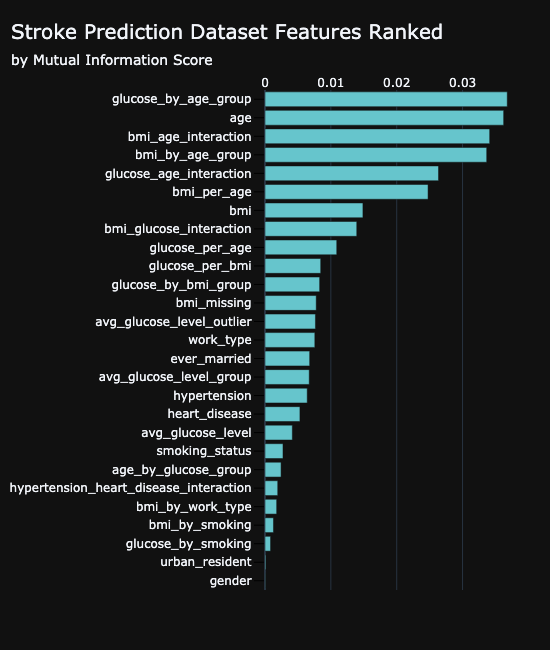

In [11]:
mutual_information_fe_df = compute_mutual_information(X=X_train, y=y_train)
plot_horizontal_bars(
    df=mutual_information_fe_df,
    feature_column="feature",
    values_column="mutual_information",
    height_px=650,
    width_px=550,
)

**Note on feature engineering effectiveness:**
- Mutual information score differs everytime it is recalculated.
- In the original dataset, there were only 3 features above 0.01, now there are 10.
    - Age and it's interaction terms are among top features.
    - Redundant features that won't be included in the model: 
        - bmi_by_age_group (redundant with bmi_age_interaction)
        - bmi_by_glucose_group (redundant with bmi_glucose_interaction)
        - bmi_group (redundant with bmi)
- Lowest contribution features: original features smoking status and two statistically non-significant features (gender and residence_type).

- Some categorical features have low MI but could still be important for decision trees and are known to be risk factors:
    - hypertension;
    - heart_disease;
    - smoking_status.

- Manually selected (_ms) features:
    - "age",
    - "bmi_age_interaction",
    - "glucose_age_interaction",
    - "bmi_per_age",
    - "bmi",
    - "bmi_glucose_interaction",
    - "glucose_per_age",
    - "bmi_missing",
    - "avg_glucose_level_outlier",
    - "work_type",
    - "hypertension",
    - "heart_disease",
    - "smoking_status".
**Note on data leakage due to data preprocessing before running a hyperparameter search algorithm with cross-validation:**
- Data leakage happens when transformation (such as group average) leaks information from the entire dataset into the test folds. 
    - There are no features among the selected ones using entire dataset info.

In [12]:
selected_features = [
    "age",
    "bmi_age_interaction",
    "glucose_age_interaction",
    "bmi_per_age",
    "bmi",
    "bmi_glucose_interaction",
    "glucose_per_age",
    "work_type",
    "hypertension",
    "heart_disease",
    "smoking_status",
    "bmi_missing",
    "avg_glucose_level_outlier",
]

In [13]:
logistic_score_fe = score_dataset_classification_task(
    X_train[selected_features], y_train, LogisticRegression(max_iter=1000)
)
print(
    f"Logistic Regression score (precision recall AUC): {logistic_score_fe:.4f}, "
    f"which is {(logistic_score_fe/logistic_score-1)*100:.2f}% "
    f"{"better" if logistic_score_fe > logistic_score else "worse"} "
    f"than the original feature set score."
)

Logistic Regression score (precision recall AUC): 0.2445, which is 5.33% better than the original feature set score.


In [14]:
feature_selection_results = pd.DataFrame(columns=["Used Features", "Score"])
used_features = []
results_list = []
for feature in selected_features:
    used_features.append(feature)
    logistic_score_fe = score_dataset_classification_task(
        X_train[used_features], y_train, LogisticRegression(max_iter=1000)
    )
    results_list.append(
        {"Used Features": ", ".join(used_features), "Score": logistic_score_fe}
    )
feature_selection_results = pd.DataFrame(results_list)
feature_selection_results

,Used Features,Score
0,age,0.167806
1,"age, bmi_age_interaction",0.229881
2,"age, bmi_age_interaction, glucose_age_interaction",0.233106
3,"age, bmi_age_interaction, glucose_age_interact...",0.234038
4,"age, bmi_age_interaction, glucose_age_interact...",0.233965
5,"age, bmi_age_interaction, glucose_age_interact...",0.249636
6,"age, bmi_age_interaction, glucose_age_interact...",0.249974
7,"age, bmi_age_interaction, glucose_age_interact...",0.257402
8,"age, bmi_age_interaction, glucose_age_interact...",0.246645
9,"age, bmi_age_interaction, glucose_age_interact...",0.241894


**Note on model improvement by engineered features:**
- Newly engineered and selected features improves Logistic Regression performance by over 5%; 
- bmi_age_interaction greatly improve model performance;
- while "hypertension", "heart_disease","smoking_status", worsense the performance.

### Automatic Feature Selection
Feature selection techniques help identify the most important features for a model automatically. The two main types are:
- Univariate feature selection: evaluates each feature individually, ignoring interactions.
- Multivariate feature selection: considers feature dependencies and interactions when selecting features.

**Note on data leakage due to data preprocessing before running a hyperparameter search algorithm with cross-validation:**
- Data leakage happens when transformation (such as group average) leaks information from the entire dataset into the test folds. 
- In case such features are automatically selected and models using these features perfomr much better than using original features, create a Custom Transformer with sklearn.base.BaseEstimator that could be used in a pipeline.

In [15]:
uni_features = select_features_lasso_kbest(X_train, y_train, n_features=13)

Selected features (LASSO + SelectKBest) (univariate FS): ['age', 'bmi', 'avg_glucose_level_group', 'bmi_age_interaction', 'glucose_age_interaction', 'bmi_glucose_interaction', 'bmi_per_age', 'glucose_per_age', 'glucose_per_bmi', 'glucose_by_age_group', 'glucose_by_bmi_group', 'bmi_by_smoking', 'bmi_by_age_group']


In [16]:
logistic_score_uni = score_dataset_classification_task(
    X_train[uni_features], y_train, LogisticRegression(max_iter=1000)
)
print(
    f"Logistic Regression score (precision recall AUC): {logistic_score_uni:.4f}, "
    f"which is {(logistic_score_uni/logistic_score_fe-1)*100:.2f}% "
    f"{"better" if logistic_score_uni > logistic_score_fe else "worse"} "
    f"than the manually selected feature set score."
)

Logistic Regression score (precision recall AUC): 0.2556, which is 4.51% better than the manually selected feature set score.


In [17]:
multi_features = select_features_rfe_lasso(X_train, y_train, n_features=13, alpha=0.01)

Selected features (LASSO + RFE) (multivariate FS): ['age', 'avg_glucose_level', 'bmi', 'smoking_status', 'bmi_age_interaction', 'glucose_age_interaction', 'bmi_glucose_interaction', 'bmi_per_age', 'glucose_per_age', 'glucose_per_bmi', 'glucose_by_smoking', 'bmi_by_smoking', 'bmi_by_work_type']


In [18]:
logistic_score_multi = score_dataset_classification_task(
    X_train[multi_features], y_train, LogisticRegression(max_iter=15000)
)
print(
    f"Logistic Regression score (precision recall AUC): {logistic_score_multi:.4f}, "
    f"which is {(logistic_score_multi/logistic_score_fe-1)*100:.2f}% "
    f"{"better" if logistic_score_multi > logistic_score_fe else "worse"} "
    f"than the manually selected feature set score."
)

Logistic Regression score (precision recall AUC): 0.2480, which is 1.42% better than the manually selected feature set score.


**Note on automatic feature selection:**
- Univariate feature selection seems to work better for the base model (logistic regression) than multivariate selection;
    - It might be explained by the fact that multivariate selection uses RandomForestClassifier and final selected features are not that optimal for the base logistic regression model.
    - Due to mutual_info_classif output variability, selected features list varies each time code is run.
- During the modeling stage, both features sets will be treid out.

### Automatic feature engineering and selection

In [ ]:
X_train_auto = train_df_encoded.copy()
y_train_auto = X_train_auto.pop(target_column)
X_train_auto = preprocess_features(X_train_auto)

af = AutoFeatRegressor(verbose=1)
X_train_auto_fe = af.fit_transform(X_train_auto, y_train_auto)

In [20]:
corr_matrix_auto = X_train_auto_fe.corr(method="spearman").abs()
high_corr_features_auto = set()
for i in range(len(corr_matrix_auto.columns)):
    for j in range(i):
        if corr_matrix_auto.iloc[i, j] > 0.9:
            colname = corr_matrix_auto.columns[i]
            high_corr_features_auto.add(colname)

print(
    f"Removed {len(high_corr_features_auto)} features out of {len(X_train_auto_fe.columns.to_list())}: {high_corr_features_auto}"
)
X_train_auto_fe = X_train_auto_fe.drop(columns=high_corr_features_auto)

Removed 5 features out of 23: {'age**3*avg_glucose_level', 'age**2*Abs(bmi)', 'age**3/avg_glucose_level', 'avg_glucose_level**3*heart_disease', 'age**3*hypertension'}


In [ ]:
X_test_auto = test_df_encoded.copy()
y_test_auto = X_test_auto.pop(target_column)
X_test_auto = preprocess_features(X_test_auto)

X_test_auto_fe = af.transform(X_test_auto)
X_test_auto_fe = X_test_auto_fe.drop(columns=high_corr_features_auto)

# Modeling
## Pipeline Setup and Model Configuration
- Tree models to be tried out:
    - Decision Tree;
    - Bagging with Decision Tree;
    - Random Forest;
    - LightGBM;
    - XGBoost.
- Feature sets:
    - Original with added two features to mark missing bmi and avergae glucose level outliers;
    - Selected: manualy engineered new features and selected based on domain knowledge;
    - Univariate FS: manualy engineered new features and selected using SelectKBest scikit learn feature selection;
    - Multivariate FS: manualy engineered new features and selected using Recursive Feature Elimination (RFE) scikit learn feature selection;
    - Auto FE and FS: automatically engineered and selected feature set.


In [22]:
no_stroke_cont = len(y_train) - y_train.sum()
stroke_count = y_train.sum()
models = {
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "XGBoost": XGBClassifier(
        scale_pos_weight=no_stroke_cont / stroke_count,
        eval_metric="aucpr",
        random_state=42,
    ),
    "LightGBM": LGBMClassifier(
        is_unbalance=True,
        random_state=42,
    ),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "Bagging with Decision Tree": BaggingClassifier(
        estimator=DecisionTreeClassifier(class_weight="balanced", random_state=42),
        random_state=42,
    ),
}

hyperparameters = {
    "XGBoost": {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.005, 0.01],
        "model__max_depth": [3, 5],
        "model__subsample": [0.5, 0.75],
        "model__colsample_bytree": [0.5, 0.75],
        "model__gamma": [0, 1],
    },
    "LightGBM": {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.005, 0.01],
        "model__max_depth": [5, 7],
        "model__num_leaves": [20, 30],
        "model__min_child_samples": [10, 20, 30, 40],
    },
    "Decision Tree": {
        "model__criterion": ["gini", "entropy"],
        "model__max_depth": [3, 5, 7, 10],
        "model__min_samples_split": [5, 10],
        "model__min_samples_leaf": [5, 10],
    },
    "Random Forest": {
        "model__n_estimators": [100, 200],
        "model__max_depth": [3, 5, 10],
        "model__min_samples_split": [5, 10],
        "model__min_samples_leaf": [5, 10],
        "model__max_features": ["sqrt", "log2"],
    },
    "Bagging with Decision Tree": {
        "model__n_estimators": [100, 200],
        "model__max_samples": [0.5, 0.75],
        "model__bootstrap": [True, False],
    },
}

feature_sets = {
    "Original Features": (
        X_train[original_features],
        y_train,
        X_test[original_features],
        y_test,
    ),
    "Selected Features": (
        X_train[selected_features],
        y_train,
        X_test[selected_features],
        y_test,
    ),
    "Univariate FS": (X_train[uni_features], y_train, X_test[uni_features], y_test),
    "Multivariate FS": (
        X_train[multi_features],
        y_train,
        X_test[multi_features],
        y_test,
    ),
    "Auto FE and FS": (X_train_auto_fe, y_train_auto, X_test_auto_fe, y_test_auto),
}

## Model Selection
### Training and Hypertuning
- Initially PR AUC was chosen scoring metric:
    - PR AUC focuses on the minority class (stroke cases), unlike ROC AUC which can be misleading in imbalanced datasets.
- Precision-Recall AUC gives higher weight to recall, making it ideal when missing strokes is costly.
- PR AUC optimized models generalized poorly, thus it was mooved on to F1:
    - It is the harmonic mean of precision and recall, providing a single score that balances both metrics. much better generalization.

In [23]:
"""
cv_results_df, cv_fold_accuracies, best_hyperparameters, confusion_matrices = (
    train_and_evaluate_models_no_smote(
        models=models,
        hyperparameters=hyperparameters,
        feature_sets=feature_sets,
        binning_info=binning_info,
        n_splits=10,
        random_search_iter=20,
        scoring_metric="f1",
    )
)
cv_results_df.to_csv("data/cv_final_run.csv")

best_hyperparameters_df_random = pd.DataFrame.from_dict(
    best_hyperparameters, orient="index"
)
best_hyperparameters_df_random.to_csv("data/parameters_final_run.csv")

feature_sets_dict = {
    "univariate_fs": uni_features,
    "multivariate_fs": multi_features,
    "auto_fe_and_fs": X_train_auto_fe.columns.to_list(),
}
feature_sets_df = pd.DataFrame(
    dict([(k, pd.Series(v)) for k, v in feature_sets_dict.items()])
)
feature_sets_df.to_csv("data/auto_selected_features_final_run.csv")

with open("data/cv_fold_accuracies_final_run.json", "w") as f:
    json.dump(cv_fold_accuracies, f, indent=4)

confusion_matrices_serializable = {
    model_name: cm.tolist() for model_name, cm in confusion_matrices.items()
}
with open("data/confusion_matrices_final_run.json", "w") as f:
    json.dump(confusion_matrices_serializable, f, indent=4)
"""

'\ncv_results_df, cv_fold_accuracies, best_hyperparameters, confusion_matrices = (\n    train_and_evaluate_models_no_smote(\n        models=models,\n        hyperparameters=hyperparameters,\n        feature_sets=feature_sets,\n        binning_info=binning_info,\n        n_splits=10,\n        random_search_iter=20,\n        scoring_metric="f1",\n    )\n)\ncv_results_df.to_csv("data/cv_final_run.csv")\n\nbest_hyperparameters_df_random = pd.DataFrame.from_dict(\n    best_hyperparameters, orient="index"\n)\nbest_hyperparameters_df_random.to_csv("data/parameters_final_run.csv")\n\nfeature_sets_dict = {\n    "univariate_fs": uni_features,\n    "multivariate_fs": multi_features,\n    "auto_fe_and_fs": X_train_auto_fe.columns.to_list(),\n}\nfeature_sets_df = pd.DataFrame(\n    dict([(k, pd.Series(v)) for k, v in feature_sets_dict.items()])\n)\nfeature_sets_df.to_csv("data/auto_selected_features_final_run.csv")\n\nwith open("data/cv_fold_accuracies_final_run.json", "w") as f:\n    json.dump(cv_

In [24]:
cv_results_df_loaded = pd.read_csv("data/cv_final_run.csv", index_col=0)
best_hyperparameters_df_random_loaded = pd.read_csv(
    "data/parameters_final_run.csv", index_col=0
)
feature_sets_df_loaded = pd.read_csv(
    "data/auto_selected_features_final_run.csv", index_col=0
)
with open("data/cv_fold_accuracies_final_run.json", "r") as f:
    cv_fold_accuracies_loaded = json.load(f)
with open("data/confusion_matrices_final_run.json", "r") as f:
    confusion_matrices_loaded = json.load(f)

### Cross Validation - F1 score

In [25]:
cv_results_df_loaded.sort_values(by="mean_cv_score", ascending=False, inplace=True)
cv_results_df_loaded.head(12)

,model,mean_cv_score,std_cv_score,f1_score_test,balanced_accuracy_test
2,LightGBM (Original Features),0.283899,0.109737,0.261981,0.795802
22,LightGBM (Auto FE and FS),0.283354,0.093149,0.229692,0.773169
0,Random Forest (Original Features),0.281195,0.063339,0.198547,0.744362
20,Random Forest (Auto FE and FS),0.280843,0.054655,0.198511,0.738992
12,LightGBM (Univariate FS),0.277079,0.078093,0.250000,0.775288
17,LightGBM (Multivariate FS),0.276733,0.084585,0.230986,0.774198
5,Random Forest (Selected Features),0.268575,0.059686,0.244776,0.784486
7,LightGBM (Selected Features),0.266794,0.091397,0.209115,0.743909
21,XGBoost (Auto FE and FS),0.263733,0.041804,0.093284,0.500000
10,Random Forest (Univariate FS),0.260437,0.054838,0.263514,0.783519


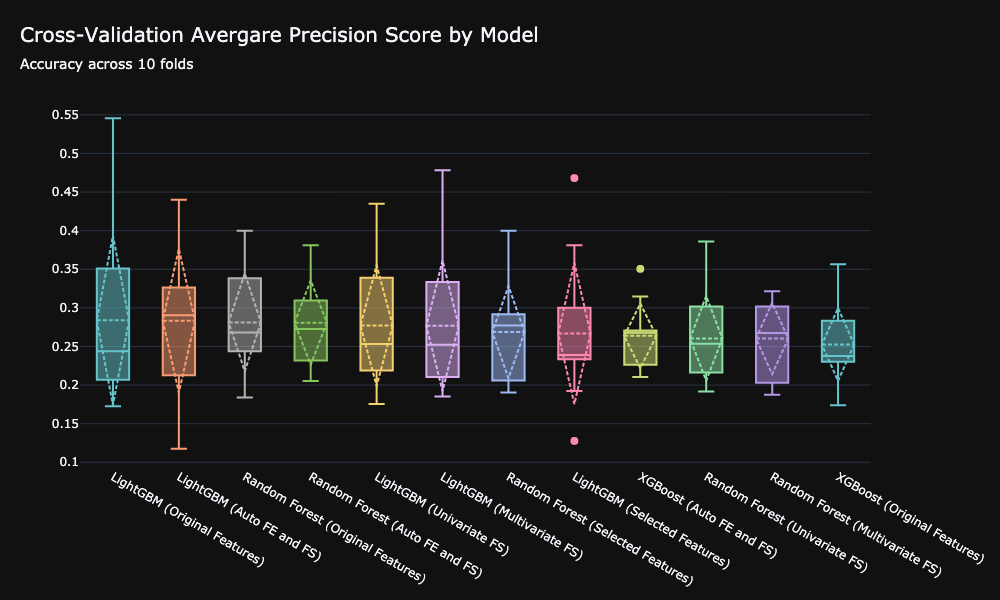

In [26]:
top_models = cv_results_df_loaded.nlargest(12, "mean_cv_score")["model"].tolist()
cv_fold_accuracies_loaded_12 = {
    k: v for k, v in cv_fold_accuracies_loaded.items() if k in top_models
}
plot_cv_boxplot(
    cv_fold_accuracies=cv_fold_accuracies_loaded_12,
    results_df=cv_results_df_loaded[:12],
    custom_text="Cross-Validation Avergare Precision Score by Model",
    custom_subtitle="Accuracy across 10 folds",
    image_name="cv_accuracy_boxplot",
    width_px=1000,
)

**Note on cross-validations results:**
- Best models:
    - LightGBM (Original Features) is the best model based on:
        - Highest f1_score_test (0.2619).
        - Best balanced_accuracy_test (0.7958).
        - Highest f1 mean_cv_score (0.2839) model performed well in cross-validation.
    - Random Forest (Univariate FS) has a slightly better f1_score_test LightGBM.
        - Higher f1_score_test (0.2635 ).
        - Good balanced_accuracy_test (0.7835).
        - Lower mean_cv_score (0.2604).
- Worse performing models are Decision Tree and Bagging with Decision Tree.

### Confusion Matrices and Other Metrics
- False Positive Rate (FPR): The proportion of actual negatives that are incorrectly identified as positives.
- False Negative Rate (FNR): The proportion of actual positives that are incorrectly identified as negatives.
- Specificity (True Negative Rate, TNR): The proportion of actual negatives that are correctly identified.
- Precision (Positive Predictive Value): The proportion of positive predictions that are actually correct. Useful when false positives are costly.
- Recall (True Positive Rate, Sensitivity): The proportion of actual positives that are correctly identified. Useful when false negatives are costly.
- Accuracy: The proportion of correctly classified instances out of the total instances.

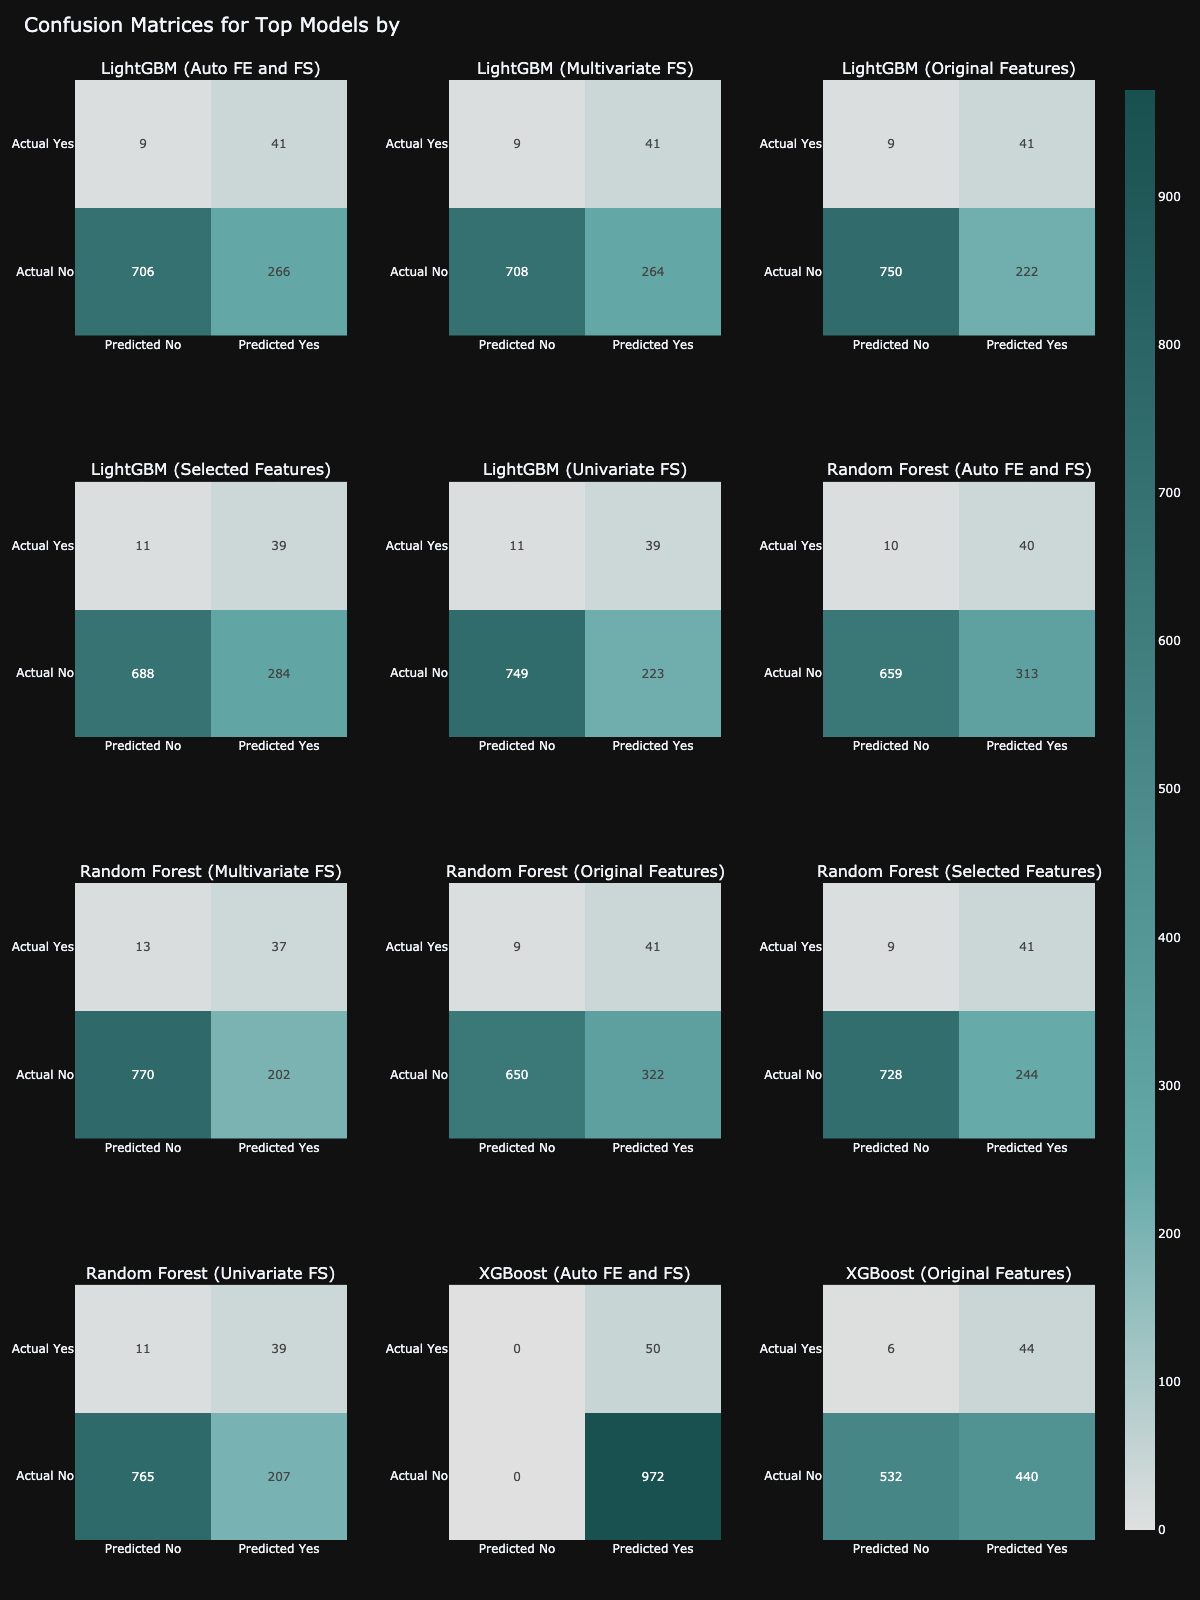

In [27]:
confusion_matrices_loaded_12 = {
    k: v for k, v in confusion_matrices_loaded.items() if k in top_models
}
plot_confusion_matrices(
    confusion_matrices=dict(sorted(confusion_matrices_loaded_12.items())),
    models_per_row=3,
    width_px=1200,
    height_px=400,
    custom_title="Confusion Matrices for Top Models by ",
)

In [28]:
metrics_df_12 = compute_classification_metrics(confusion_matrices_loaded_12)
metrics_df_12["sum_fr"] = metrics_df_12["fnr"] + metrics_df_12["fpr"]
metrics_df_12.sort_values(by="sum_fr")

,fpr,fnr,recall_tpr,precision,specificity_tnr,accuracy,sum_fr
LightGBM (Original Features),0.228395,0.18,0.82,0.155894,0.771605,0.773973,0.408395
Random Forest (Selected Features),0.251029,0.18,0.82,0.143860,0.748971,0.752446,0.431029
Random Forest (Univariate FS),0.212963,0.22,0.78,0.158537,0.787037,0.786693,0.432963
LightGBM (Univariate FS),0.229424,0.22,0.78,0.148855,0.770576,0.771037,0.449424
LightGBM (Multivariate FS),0.271605,0.18,0.82,0.134426,0.728395,0.732877,0.451605
LightGBM (Auto FE and FS),0.273663,0.18,0.82,0.133550,0.726337,0.730920,0.453663
Random Forest (Multivariate FS),0.207819,0.26,0.74,0.154812,0.792181,0.789628,0.467819
Random Forest (Original Features),0.331276,0.18,0.82,0.112948,0.668724,0.676125,0.511276
LightGBM (Selected Features),0.292181,0.22,0.78,0.120743,0.707819,0.711350,0.512181
Random Forest (Auto FE and FS),0.322016,0.20,0.80,0.113314,0.677984,0.683953,0.522016


**Note on best model and further steps:**
- Best overall model:  LightGBM (Original Features)
    - Best balance of recall (0.82), precision (0.1559), and accuracy (0.7740).
    - Lowest FNR (0.18) and one of the lowest FPR (0.2284).
- Next steps: retain LightGBM model with adjusted hyperparameter options using original data set features.

## Retraining LightGBM Model
- Previous best hyperparameters will be used to tweak possible parameters for the tunning.
- Threshold will be lowered a bit to reduce false negatives even further.
- Other scoring metrics might be explored.

In [29]:
feature_set = {
    "Original Features": (
        X_train[original_features],
        y_train,
        X_test[original_features],
        y_test,
    ),
}
best_inter_models = {
    "LightGBM": LGBMClassifier(
        importance_type="gain",
        is_unbalance=True,
        random_state=42,
    ),
}
best_inter_hyperparameters_lg = {
    "LightGBM": {
        "model__n_estimators": [50, 100, 150, 200],
        "model__max_depth": [5, 6, 7, 8],
        "model__learning_rate": [0.005, 0.01, 0.015],
        "model__num_leaves": [17, 20, 22, 25],
        "model__min_child_samples": [15, 20, 35],
        "model__subsample": [0.7, 0.85, 1.0],
        "model__colsample_bytree": [0.5, 0.75, 1.0],
    }
}

In [ ]:
(
    lg_cv_results_df,
    lg_cv_fold_accuracies,
    lg_best_hyperparameters,
    lg_confusion_matrices,
) = train_and_evaluate_models_no_smote(
    models=best_inter_models,
    hyperparameters=best_inter_hyperparameters_lg,
    feature_sets=feature_set,
    binning_info=binning_info,
    n_splits=10,
    random_search_iter=20,
    scoring_metric="f1",
)

In [31]:
lg_cv_results_df

,model,mean_cv_score,std_cv_score,f1_score_test,balanced_accuracy_test
0,LightGBM (Original Features),0.267574,0.051385,0.195238,0.740761


In [32]:
lg_metrics_df = compute_classification_metrics(lg_confusion_matrices)
lg_metrics_df

,fpr,fnr,recall_tpr,precision,specificity_tnr,accuracy
LightGBM (Original Features),0.338477,0.18,0.82,0.110811,0.661523,0.669276


**Note on additional expanded hyperparameter tunning:**
- Hyperparameter ranges created based on best parameters found when comparing to other models increase false positive rate, decreases the accuracy.
- Model will be trained based on paramters found in previous step.
- Probability threshold was also treid out: by decreasing it, fpr increase, but no positive effect in fnr, while increasing threshold causes drastic increase in fnr and decrease in fpr.

### Feature Importance - SHAP
Permutations method will be used to detect irrelevant features to retrain the model with only relevant ones. 
Understanding SHAP values:
- Positive values increase the model's prediction probability.
- Negative values decrease the model's prediction probability.
- Closer to 0 have less impact on the prediction.
- Color represents feature value:
    - Red (high feature value): Higher feature values.
    - Blue (low feature value): Lower feature values.
    - Example Insight: If age is red and has high SHAP values on the positive side → Older individuals are more likely to get a higher model prediction (e.g., higher risk in a medical model).

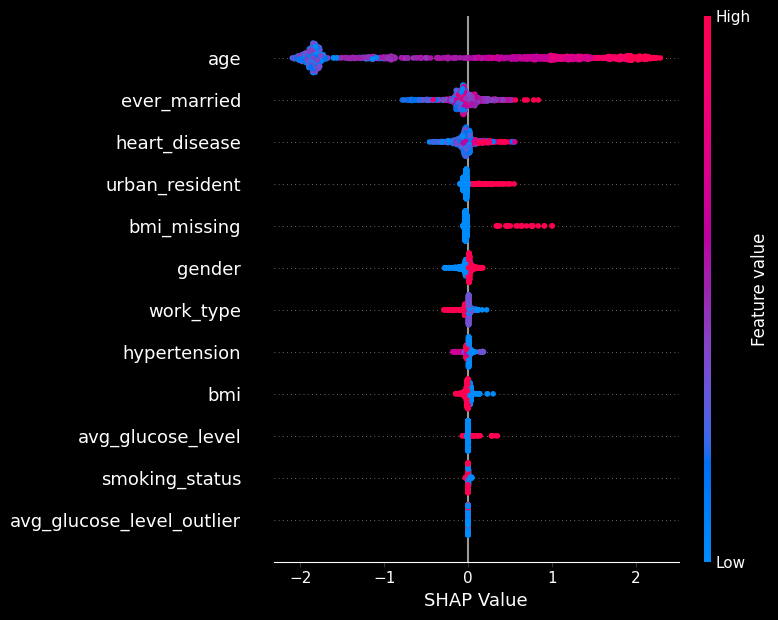

In [33]:
model = LGBMClassifier(
    importance_type="gain",
    is_unbalance=True,
    random_state=42,
    n_estimators=100,
    max_depth=7,
    learning_rate=0.01,
    num_leaves=20,
    min_child_samples=20,
)
preprocessor = create_dynamic_preprocessor(
    X=X_train[original_features], binning_info=binning_info
)
X_train_transformed = preprocessor.fit_transform(X_train[original_features])
X_test_transformed = preprocessor.transform(X_test[original_features])

X_train_transformed = pd.DataFrame(X_train_transformed, columns=original_features)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=original_features)

model.fit(X_train_transformed, y_train)

explainer = shap.TreeExplainer(model, X_train_transformed, model_output="raw")
shap_values = explainer.shap_values(X_test_transformed, check_additivity=False)
plot_shap_summary(
    shap_values,
    X_test_transformed,
)

**Note on SHAP values:**
- Age shows high variability in SHAP values, indicating it is a key predictor.
    - Older individuals tend to have higher model predictions.
- Heart disease and ever married have relatively smaller SHAP values, suggesting a weaker impact compared to age.
    - For heart disease, higher SHAP values correspond to higher feature values (more red dots), indicating that having heart disease increases the prediction probability.
    - Ever married follows a similar pattern, with positive SHAP values aligning with higher feature values.
- BMI missing appears to contribute positively, meaning missing BMI data may increase the model's prediction probability.
- avg_glucose_level_outlier has SHAP values close to zero, indicating it has minimal impact. Drop this feature.
- Smoking status has small positive and negative SHAP values, suggesting a minor influence on the model's predictions.

In [34]:
final_features = [
    feature for feature in original_features if feature != "avg_glucose_level_outlier"
]
print(final_features)

['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'urban_resident', 'avg_glucose_level', 'bmi', 'smoking_status', 'bmi_missing']


### Saving the Model

In [35]:
preprocessor = create_dynamic_preprocessor(X_train[final_features], binning_info)
preprocessor.fit(X_train[final_features])
X_train_transformed = preprocessor.transform(X_train[final_features])
X_train_transformed = pd.DataFrame(X_train_transformed, columns=final_features)

best_model = LGBMClassifier(
    importance_type="gain",
    is_unbalance=True,
    random_state=42,
    n_estimators=100,
    max_depth=7,
    learning_rate=0.01,
    num_leaves=20,
    min_child_samples=20,
)
best_model.fit(X_train_transformed, y_train, feature_name=final_features)

final_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("model", best_model),
    ]
)
joblib.dump(final_pipeline, "lightgbm.joblib")
print("Model trained and saved successfully!")

loaded_pipeline = joblib.load("lightgbm.joblib")
X_test_transformed = loaded_pipeline.named_steps["preprocessor"].transform(
    X_test[final_features]
)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=final_features)
y_pred = loaded_pipeline.named_steps["model"].predict(X_test_transformed)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Test Accuracy: {accuracy:.4f}")

Model trained and saved successfully!
Model Test Accuracy: 0.9080


# Closing Remarks on Feature Engineering and Best Model Selection
- LightGBM model worked the best using original data set features with additional marker for missing BMI.
- The most important predictor is age.
- There were multiple things tried out in order to increse model's performance:
    - Different feature sets: manually engineered and selected, automatically selected and automatically engineered and selected.
        - Original features seem to work best.
        - Feature engineering seems to introduce high multicollinearity.
    - Five tree models tried out from simple Decision tree to ensambles to boosting.
    - Variuous techniques:
        - No significant improvement:
            - RepeatedStratifiedKFold instead of StratifiedKFold
                - No improvement in performance, only increased runtime.
                - Kept StratifiedKFold as it’s faster.
            - GridSearch Instead of RandomizedSearchCV.
            - SMOTEENN Resampling: caused massive overfitting (accuracy near 1.0 but bad generalization).
            - SMOTE Resampling: slightly improved precision-recall, but still bad generalization.
            - Standard scaling.
        - Helpful:
            - F1 scoring metric worked better than precision recall.
            - Manually setting probability threshold to 0.3 instead of 0.5.
                - Also tried values in range [0.2 to 0.4], which significantl increased eithe fnr or fpr.
            - Filling missing values with median and marking missing bmi observations instead of just filling with -999.